## Load Data

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
import tensorflow as tf
import glob
from scipy import interpolate
from collections import Counter
import os
from itertools import product

plt.style.use("dark_background")

types_vocab = ["EXP", "HIB", "LP", "PIS", "TOR", "TR", "VT"]

In [2]:
try:
    table = pd.read_pickle("data/table.pkl")
except:
    table = pd.read_excel("data/association_table_corrected_index.xlsx")


In [3]:
table.head()


,Index,Event,Duration,Event start,Event stop,File name,File start,File end,Sampling rate,Overlap,Unnamed: 10,Unnamed: 11,Unnamed: 12,npts,energy,path
0,0,LP1,33,2006-05-23 20:39:27.060000+00:00,2006-05-23 20:40:00.060000+00:00,20060523_2033.UB1.SL.Z.sac,2006-05-23 20:33:05.895000+00:00,2006-05-23 20:43:05.885000+00:00,100.0,False,NaN,NaN,NaN,60000.0,0.24403,C:/Users/EC265595/Documents/Data/Ubinas_2006_2...
1,1,LP1,45,2006-05-23 20:39:59.960000+00:00,2006-05-23 20:40:44.960000+00:00,20060523_2033.UB1.SL.Z.sac,2006-05-23 20:33:05.895000+00:00,2006-05-23 20:43:05.885000+00:00,100.0,False,NaN,NaN,NaN,60000.0,0.11833,C:/Users/EC265595/Documents/Data/Ubinas_2006_2...
2,2,TR2,128,2006-05-23 22:37:52.910000+00:00,2006-05-23 22:40:00.910000+00:00,20060523_2235.UB1.SL.Z.sac,2006-05-23 22:35:19.895000+00:00,2006-05-23 23:05:19.875000+00:00,50.0,False,NaN,NaN,NaN,90000.0,0.79052,C:/Users/EC265595/Documents/Data/Ubinas_2006_2...
3,3,LP1,32,2006-05-23 22:44:09.410000+00:00,2006-05-23 22:44:41.410000+00:00,20060523_2235.UB1.SL.Z.sac,2006-05-23 22:35:19.895000+00:00,2006-05-23 23:05:19.875000+00:00,50.0,False,NaN,NaN,NaN,90000.0,1.15570,C:/Users/EC265595/Documents/Data/Ubinas_2006_2...
4,4,TR2,78,2006-05-23 22:46:58.440000+00:00,2006-05-23 22:48:16.440000+00:00,20060523_2245.UB1.SL.Z.sac,2006-05-23 22:45:19.895000+00:00,2006-05-23 22:55:19.885000+00:00,100.0,False,NaN,NaN,NaN,60000.0,0.23330,C:/Users/EC265595/Documents/Data/Ubinas_2006_2...


In [4]:
if not os.path.isfile("data/table.pkl"):
    table.to_pickle("data/table.pkl")


## Make list of spectrograms

In [5]:
table.Event.value_counts().min()


67

In [2]:
TRAIN_SIZE = 78
TEST_SIZE = 20


In [3]:
T_MAX = 120
F_MAX = 20

T_DIM = 50
F_DIM = 50

t_itp = np.linspace(0, T_MAX, T_DIM)
f_itp = np.linspace(0, F_MAX, F_DIM)


In [102]:
dict_interps = dict()
counter = Counter()
list_interps = []
list_types = []


In [103]:
# shuffle the dataframe
table = table.sample(frac=1)


In [104]:
# ts = np.load(f"data/Extracted/EXP/EXP_128.npy")
# f, t, S = signal.spectrogram(ts, row["Sampling rate"])
# func = interpolate.RectBivariateSpline(f, t, S)
# plt.imshow(S)

In [105]:
for index, row in table.iterrows():
    event = row["Event"]
    event_type = event if event in types_vocab else event[:-1]
    if counter[event_type] >= TRAIN_SIZE + TEST_SIZE:
        continue
    name = event_type + "_" + str(row["Index"])
    filename = name + ".npy"
    try:
        ts = np.load(f"data/Extracted/{event_type}/{filename}")
        f, t, S = signal.spectrogram(ts, row["Sampling rate"])
        func = interpolate.RectBivariateSpline(f, t, S)
        # func = interpolate.interp2d(f,t,S, fill_value = 0)
    except:
        continue
    S_int = func(f_itp, t_itp)
    for (i, f_i), (j, t_j) in product(enumerate(f_itp),enumerate(t_itp)):
        if f_i > f.max() or t_j > t.max():
            S_int[i,j] = 0
    # dict_interps[name] = S_int
    list_interps.append(S_int)
    list_types.append(event_type)
    counter[event_type] += 1


In [106]:
len(list_interps)


686

In [107]:
Counter(list_types)


Counter({'PIS': 98,
         'LP': 98,
         'TR': 98,
         'EXP': 98,
         'VT': 98,
         'HIB': 98,
         'TOR': 98})

In [108]:
# np.savez("./dataset_spectro", **dict_interps)

## Datasets

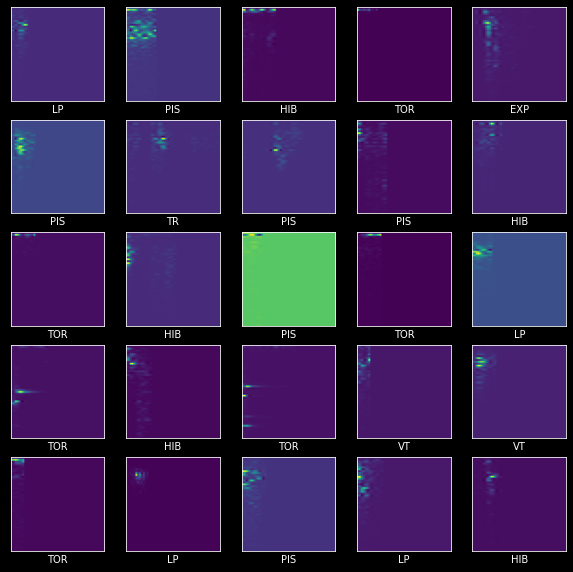

In [109]:
plt.figure(figsize=(10,10))
perm = np.random.permutation(len(list_interps))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(list_interps[perm[i]])
    plt.xlabel(list_types[perm[i]])
plt.show()

In [110]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
list_types_num = le.fit_transform(list_types)


In [111]:
# dataset = tf.data.Dataset.from_tensor_slices((list_interps, list_types_num))
# dataset

In [112]:
dataset = tf.data.Dataset.from_tensor_slices((list_interps, list_types_num))
dataset = dataset.shuffle(TEST_SIZE + TRAIN_SIZE)
test_dataset = dataset.take(TEST_SIZE)
train_dataset = dataset.skip(TEST_SIZE)
test_dataset = test_dataset.batch(1)
train_dataset = train_dataset.batch(5)
# train_dataset = tf.data.Dataset.from_tensor_slices((list_interps[:20], list_types[:20]))
# test_dataset = tf.data.Dataset.from_tensor_slices((list_interps[20:], list_types[20:]))

In [113]:
test_dataset

<BatchDataset shapes: ((None, 50, 50), (None,)), types: (tf.float64, tf.int64)>

/tmp/ipykernel_30319/1936445080.py:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t_itp, f_itp, list_interps[8])


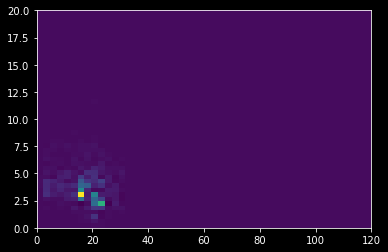

In [114]:
plt.pcolormesh(t_itp, f_itp, list_interps[8])

In [5]:
from tensorflow.keras import datasets, layers, models

In [6]:
dropout_rate = 0.1

model = models.Sequential()
model.add(layers.Reshape((T_DIM, F_DIM, 1), input_shape=(T_DIM, F_DIM)))
model.add(layers.Conv2D(32, (3, 3), activation="relu")) #, input_shape=(50, 25, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation="relu"))
model.add(layers.Flatten())
model.add(layers.Dropout(dropout_rate))
model.add(layers.Dense(32, activation="relu"))
model.add(layers.Dropout(dropout_rate))
model.add(layers.Dense(7))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 50, 50, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 48, 48, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 22, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 32)          18464     
_________________________________________________________________
flatten (Flatten)            (None, 2592)              0

2021-11-19 11:19:11.437495: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-19 11:19:12.401196: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2033 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:b1:00.0, compute capability: 7.5


In [7]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

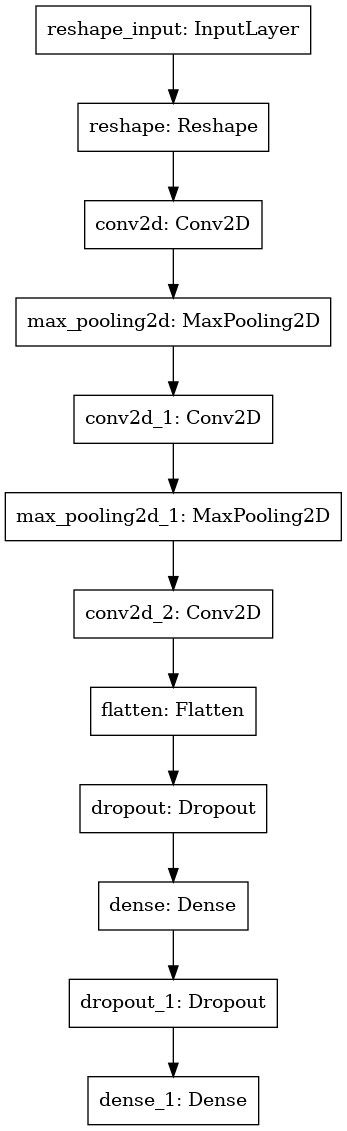

In [8]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file="graphes/model.png")

In [118]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor="accuracy", patience=10, restore_best_weights=True
)

In [119]:
history = model.fit(train_dataset, epochs=50, callbacks=[early_stopping])

Epoch 1/50
134/134 [==============================] - 2s 6ms/step - loss: 3212.2698 - accuracy: 0.3964
Epoch 2/50
134/134 [==============================] - 0s 4ms/step - loss: 1663.3461 - accuracy: 0.2913
Epoch 3/50
134/134 [==============================] - 0s 3ms/step - loss: 477.4902 - accuracy: 0.2793
Epoch 4/50
134/134 [==============================] - 0s 3ms/step - loss: 5.0063 - accuracy: 0.2192
Epoch 5/50
134/134 [==============================] - 0s 3ms/step - loss: 2.5379 - accuracy: 0.1967
Epoch 6/50
134/134 [==============================] - 0s 3ms/step - loss: 1.9891 - accuracy: 0.1742
Epoch 7/50
134/134 [==============================] - 0s 3ms/step - loss: 2.2121 - accuracy: 0.1712
Epoch 8/50
134/134 [==============================] - 0s 4ms/step - loss: 1.8649 - accuracy: 0.1862
Epoch 9/50
134/134 [==============================] - 0s 3ms/step - loss: 2.0027 - accuracy: 0.1592
Epoch 10/50
134/134 [==============================] - 0s 3ms/step - loss: 2.1128 - accuracy

In [ ]:
loss: 3212.2698 - accuracy: 0.3964
loss: 1663.3461 - accuracy: 0.2913
loss: 477.4902 - accuracy: 0.2793
loss: 5.0063 - accuracy: 0.2192
loss: 2.5379 - accuracy: 0.1967
loss: 1.9891 - accuracy: 0.1742
loss: 2.2121 - accuracy: 0.1712
loss: 1.8649 - accuracy: 0.1862
loss: 2.0027 - accuracy: 0.1592
loss: 2.1128 - accuracy: 0.1486
loss: 2.2268 - accuracy: 0.1396

In [120]:
model.evaluate(test_dataset)

20/20 [==============================] - 0s 3ms/step - loss: 1184.0067 - accuracy: 0.0500


[1184.0067138671875, 0.05000000074505806]